# Random Forest

In [3]:
import os
import re

project_path = re.findall(
    pattern=r".+monday-vip-consulting",
    string=os.path.abspath(os.getcwd()),
)[0]
os.chdir(os.path.join(project_path))
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.pather import Pather
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

## Train

In [61]:
pather = Pather()
features = pd.read_csv(pather.features).set_index("account_id")
y = pd.read_csv(pather.target).set_index("account_id")["lead_score"].values


use_categorical = True
categorical_cols = ["payment_currency", "industry"]
if not use_categorical:
    features = features.drop(categorical_cols, axis=1)
    X_encoded = features.values
else:
    one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
    preprocessor = ColumnTransformer(
        transformers=[("cat", one_hot_encoder, categorical_cols)],
        remainder="passthrough",
    )
    X_encoded = preprocessor.fit_transform(features)

/Users/yonatanf/Documents/scripts/monday-vip-consulting/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [62]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

In [63]:
n_estimators = 10
max_depth = 10

rf_classifier = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=30,
    class_weight="balanced",
)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_val_pred = rf_classifier.predict(X_val)
y_test_pred = rf_classifier.predict(X_test)

train_precision = precision_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"Train precision: {train_precision}")
print(f"Val precision: {val_precision}")
print(f"Test precision: {test_precision}")
print(f"Random Model: {sum(y == 1) / len(y)}")

Train precision: 0.7711162850860174
Val precision: 0.23294723294723294
Test precision: 0.23444662737393582
Random Model: 0.026223742610660763


Log:

n_estimators, max_depth, is_cat, precision

    50, 30, True, 0.23

## Feature Importance

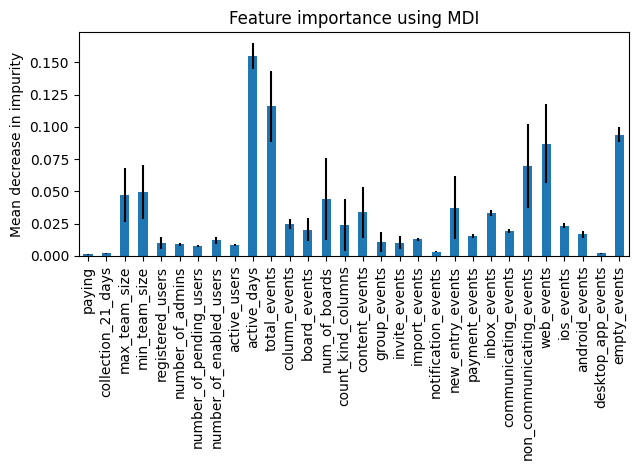

In [56]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importance = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Grid Search

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [30, 40, 50]
}
rf_classifier = RandomForestClassifier(random_state=42, class_weight="balanced",)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='precision',)
grid_search.fit(X_train, y_train)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

final_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
final_rf_model.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_val_pred = rf_classifier.predict(X_val)
y_test_pred = rf_classifier.predict(X_test)

train_precision = precision_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"Train precision: {train_precision}")
print(f"Val precision: {val_precision}")
print(f"Test precision: {test_precision}")